source: https://keras.io/examples/vision/edsr

#Mount drive

In [ ]:
import os,shutil

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#Install Libraries

In [ ]:
!pip install tensorflow_datasets==4.8

#Imports

In [ ]:
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt

from tensorflow import keras
from tensorflow.keras import layers

AUTOTUNE = tf.data.AUTOTUNE

In [ ]:
tf.__version__

'2.8.0'

In [ ]:
tfds.__version__

'4.8.0'

In [ ]:
np.__version__

'1.22.4'

#Download the training dataset

In [ ]:
# Download DIV2K from TF Datasets
# Using bicubic 4x degradation type
div2k_data = tfds.image.Div2k(config="bicubic_x4")
div2k_data.download_and_prepare()

# Taking train data from div2k_data object
train = div2k_data.as_dataset(split="train", as_supervised=True)
#to cache elements of a dataset in memory or on disk, so subsequent itrations over the dataset
#will use the cached data instead of reading from the original source. which can improve the performance od data processing.
train_cache = train.cache()
# Validation data
val = div2k_data.as_dataset(split="validation", as_supervised=True)
val_cache = val.cache()

EXTRACTING {'train_lr_url': 'https://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_train_LR_bicubic_X4.zip', 'valid_lr_url': 'https://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_valid_LR_bicubic_X4.zip', 'train_hr_url': 'https://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_train_HR.zip', 'valid_hr_url': 'https://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_valid_HR.zip'}


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/800 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/div2k/bicubic_x4/2.0.0.incompleteGHJ9KL/div2k-train.tfrecord*...:   0%|   …

Generating validation examples...:   0%|          | 0/100 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/div2k/bicubic_x4/2.0.0.incompleteGHJ9KL/div2k-validation.tfrecord*...:   0…

Dataset div2k downloaded and prepared to /root/tensorflow_datasets/div2k/bicubic_x4/2.0.0. Subsequent calls will reuse this data.


In [ ]:
print(len(train_cache))
print(len(val_cache))

800
100


#Flip, crop and resize images

In [ ]:
def flip_left_right(lowres_img, highres_img):
    """Flips Images to left and right."""

    # Outputs random values from a uniform distribution in between 0 to 1
    rn = tf.random.uniform(shape=(), maxval=1)
    # If rn is less than 0.5 it returns original lowres_img and highres_img
    # If rn is greater than 0.5 it returns flipped image
    return tf.cond(
        rn < 0.5,
        lambda: (lowres_img, highres_img),
        lambda: (
            tf.image.flip_left_right(lowres_img),
            tf.image.flip_left_right(highres_img),
        ),
    )


def random_rotate(lowres_img, highres_img):
    """Rotates Images by 90 degrees."""

    # Outputs random values from uniform distribution in between 0 to 4
    rn = tf.random.uniform(shape=(), maxval=4, dtype=tf.int32)
    # Here rn signifies number of times the image(s) are rotated by 90 degrees
    return tf.image.rot90(lowres_img, rn), tf.image.rot90(highres_img, rn)

# hr_crop_size=96 , 144, 192
def random_crop(lowres_img, highres_img, hr_crop_size=192, scale=4):
    """Crop images.

    for scale = 4
    low resolution images: 48x48 (we change it from 24 to 48)
    hight resolution images: 192x192
    """
    #calculates the size of the low resolution crop based on the scaling factor.
    lowres_crop_size = hr_crop_size // scale  # 192//4=48
    lowres_img_shape = tf.shape(lowres_img)[:2]  # (height,width)

    #randomly selects a starting point for the crop within the input images
    lowres_width = tf.random.uniform(
        shape=(), maxval=lowres_img_shape[1] - lowres_crop_size + 1, dtype=tf.int32
    )
    lowres_height = tf.random.uniform(
        shape=(), maxval=lowres_img_shape[0] - lowres_crop_size + 1, dtype=tf.int32
    )

    highres_width = lowres_width * scale
    highres_height = lowres_height * scale

    #uses slicing to extract the cropped regions from the input images
    lowres_img_cropped = lowres_img[
        lowres_height : lowres_height + lowres_crop_size,
        lowres_width : lowres_width + lowres_crop_size,
    ]  # 48x48
    highres_img_cropped = highres_img[
        highres_height : highres_height + hr_crop_size,
        highres_width : highres_width + hr_crop_size,
    ]  # 192x192

    return lowres_img_cropped, highres_img_cropped


#Prepare a tf.Data.Dataset object

We augment the training data with random horizontal flips and 90 rotations.

As low resolution images, we use 48x48 RGB input patches.

In [ ]:
def dataset_object(dataset_cache, training=True):

  ds = dataset_cache
  #map(): the inputs are a function and a dataset and returns a new dataset where the function has been applied to each element of dataset.
  ds = ds.map(
      lambda lowres, highres: random_crop(lowres, highres, scale=4),
      num_parallel_calls=AUTOTUNE,
    ) #num_parallel_calls=AUTOTUNE passed to map() for speed up the processing for large dataset.

  if training:
    ds = ds.map(random_rotate, num_parallel_calls=AUTOTUNE)
    ds = ds.map(flip_left_right, num_parallel_calls=AUTOTUNE)
  # Batching Data for group together multiple data into batches. for improve speed of traning
  ds = ds.batch(16)

  if training:
    # Repeating Data, so that cardinality if dataset becomes infinte
    #number of times to repeat dataset, it allows the model to see the same data multiple times during training
    #which can improve its ability to learn patterns and generalize to new data.
    ds = ds.repeat()

  # prefetching allows later images to be prepared while the current image is being processed
  ds = ds.prefetch(buffer_size=AUTOTUNE)
  return ds


train_ds = dataset_object(train_cache, training=True)
val_ds = dataset_object(val_cache, training=False)

In [ ]:
#lengt_dataset = train_ds.reduce(0, lambda x,_: x+1).numpy()
#len(list(train_ds)) #infinite data , without repeat the num of train_ds group is 50.
print("num of group of batching data for validation:", len(list(val_ds))) #100 data , batch_size=16 , num_group = 7

num of group of batching data for validation: 7


#Visualize the data

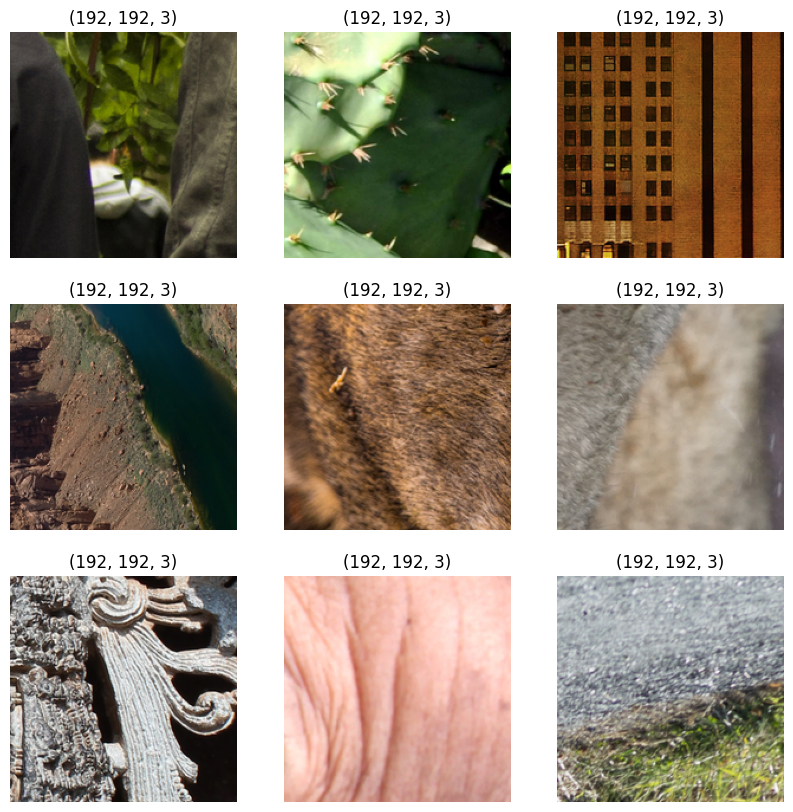

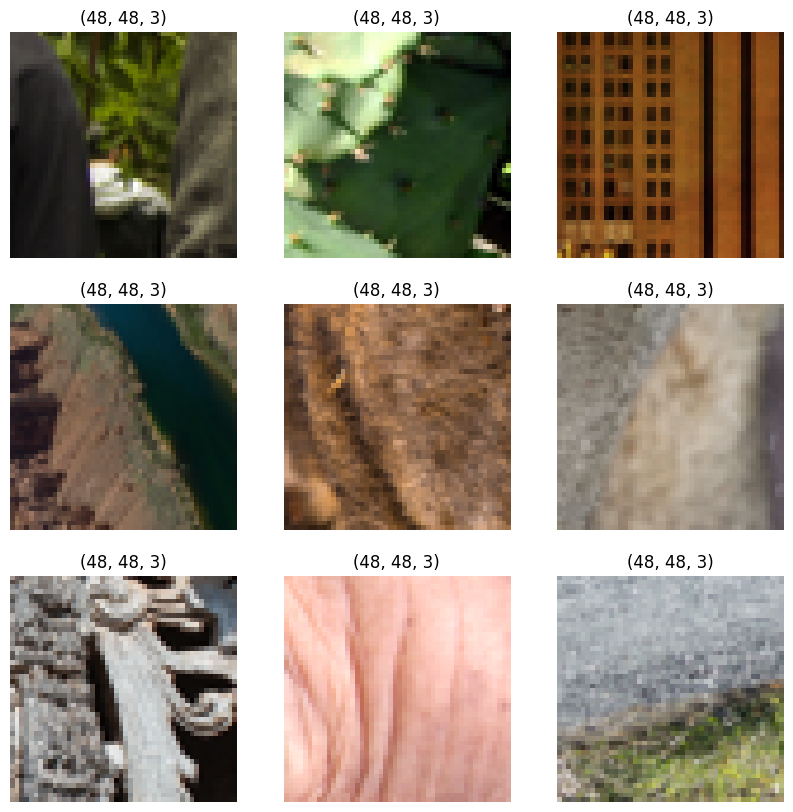

In [ ]:
lowres, highres = next(iter(train_ds))

# Hight Resolution Images
plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(highres[i].numpy().astype("uint8"))
    plt.title(highres[i].shape)
    plt.axis("off")

# Low Resolution Images
plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(lowres[i].numpy().astype("uint8"))
    plt.title(lowres[i].shape)
    plt.axis("off")


#Build the model

In [ ]:
class EDSRModel(tf.keras.Model):
    def train_step(self, data):
        # Unpack the data. Its structure depends on your model and
        # on what you pass to `fit()`.
        x, y = data

        with tf.GradientTape() as tape:
            y_pred = self(x, training=True)  # Forward pass
            # Compute the loss value
            # (the loss function is configured in `compile()`)
            loss = self.compiled_loss(y, y_pred, regularization_losses=self.losses)

        # Compute gradients
        trainable_vars = self.trainable_variables
        gradients = tape.gradient(loss, trainable_vars)
        # Update weights
        self.optimizer.apply_gradients(zip(gradients, trainable_vars))
        # Update metrics (includes the metric that tracks the loss)
        self.compiled_metrics.update_state(y, y_pred)
        # Return a dict mapping metric names to current value
        return {m.name: m.result() for m in self.metrics}

    def predict_step(self, x):
        # Adding dummy dimension using tf.expand_dims and converting to float32 using tf.cast
        x = tf.cast(tf.expand_dims(x, axis=0), tf.float32)
        # Passing low resolution image to model
        super_resolution_img = self(x, training=False)
        # Clips the tensor from min(0) to max(255)
        super_resolution_img = tf.clip_by_value(super_resolution_img, 0, 255)
        # Rounds the values of a tensor to the nearest integer
        super_resolution_img = tf.round(super_resolution_img)
        # Removes dimensions of size 1 from the shape of a tensor and converting to uint8
        super_resolution_img = tf.squeeze(
            tf.cast(super_resolution_img, tf.uint8), axis=0
        )
        return super_resolution_img

In [ ]:
# Residual Block
def ResBlock(inputs):
    #num of channels = 3 = RGB
    #padding same => the output should have the same spatial dim as the input.
    x = layers.Conv2D(64, 3, padding="same", activation="relu")(inputs)
    x = layers.Conv2D(64, 3, padding="same")(x)
    x = layers.Add()([inputs, x]) # => inputs + x
    return x

# Upsampling Block
def Upsampling(inputs, factor=2, **kwargs ):
    x = layers.Conv2D(64 * (factor ** 2), 3, padding="same" ,**kwargs)(inputs)
    #outputs a copy of the input tensor where values from the depth dimension are moved
    #in spatial blocks to the height and width dimensions.
    #block_size = how the data is moved.
    x = tf.nn.depth_to_space(x, block_size=factor)
    x = layers.Conv2D(64 * (factor ** 2), 3, padding="same" ,**kwargs)(x)
    x = tf.nn.depth_to_space(x, block_size=factor)
    return x


def make_model(num_filters, num_of_residual_blocks):
    # Flexible Inputs to input_layer
    input_layer = layers.Input(shape=(None, None, 3))
    # Scaling Pixel Values
    x = layers.Rescaling(scale=1.0 / 255)(input_layer)
    x = x_new = layers.Conv2D(num_filters, 3, padding="same")(x)

    # 16 residual blocks
    for _ in range(num_of_residual_blocks):
        x_new = ResBlock(x_new)

    x_new = layers.Conv2D(num_filters, 3, padding="same")(x_new)
    x = layers.Add()([x, x_new])

    x = Upsampling(x)
    x = layers.Conv2D(3, 3, padding="same")(x)

    output_layer = layers.Rescaling(scale=255)(x)
    return EDSRModel(input_layer, output_layer)


model = make_model(num_filters=64, num_of_residual_blocks=16)

#metrics

In [ ]:
def PSNR(super_resolution, high_resolution):
    """Compute the peak signal-to-noise ratio, measures quality of image."""
    # Max value of pixel is 255
    psnr_value = tf.image.psnr(high_resolution, super_resolution, max_val=255)
    return psnr_value

#Train the model

In [ ]:
!pip install livelossplot

In [ ]:
#from livelossplot import PlotLossesKeras

#tf.random.set_seed(0)

# Using adam optimizer with initial learning rate as 1e-4, changing learning rate after 5000 steps to 5e-5
optim_edsr = keras.optimizers.Adam(
    learning_rate=keras.optimizers.schedules.PiecewiseConstantDecay(
        boundaries=[5000], values=[1e-4, 5e-5]
    )
)
# Compiling model with loss as mean absolute error(L1 Loss) and metric as psnr
model.compile(optimizer=optim_edsr, loss="mae" , metrics=[PSNR])

# Training for more epochs will improve results
history_mae_x4 = model.fit(train_ds, epochs=100, steps_per_epoch=200, validation_data=val_ds ) #, callbacks=[PlotLossesKeras()]

Epoch 1/100
 45/200 [=====>........................] - ETA: 3:13 - loss: 468.2833 - PSNR: -0.8367

KeyboardInterrupt: ignored

#save model

In [ ]:
model.save('./drive/MyDrive/ColabNotebooks/EDSR-Tensorflow/models/model_mae_x4.h5') #model.h5 or model.tf

#save history

In [ ]:
#source: https://stackoverflow.com/questions/41061457/keras-how-to-save-the-training-history-attribute-of-the-history-object

import pickle

with open('./drive/MyDrive/ColabNotebooks/EDSR-Tensorflow/history/history_mae_x4', 'wb') as file_pi:
  pickle.dump(history_mae_x4.history, file_pi)

#compare training loss vs validation loss

In [ ]:
#source: https://github.com/fchollet/deep-learning-with-python-notebooks/blob/master/first_edition/5.3-using-a-pretrained-convnet.ipynb

def smooth_curve(points, factor=0.8):
  smoothed_points = []
  for point in points:
    if smoothed_points:
      previous = smoothed_points[-1]
      smoothed_points.append(previous * factor + point * (1 - factor))
    else:
      smoothed_points.append(point)
  return smoothed_points

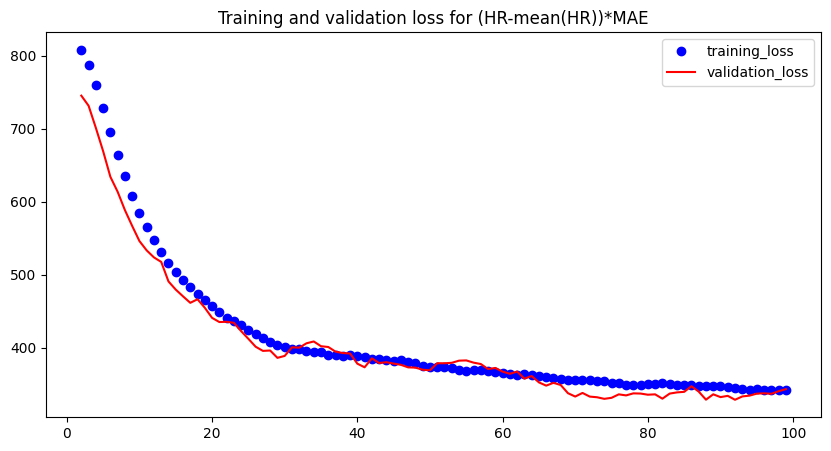

<Figure size 640x480 with 0 Axes>

In [ ]:
import pickle
import matplotlib.pyplot as plt

history_mae_x4 = pickle.load(open('./drive/MyDrive/ColabNotebooks/EDSR-Tensorflow/history/history_mae_x4', "rb"))

epochs = range(2,len(history_mae_x4["loss"]))

fig, ax = plt.subplots(figsize=(10,5))

ax.plot(epochs, smooth_curve(history_mae_x4["loss"][2:]), 'bo', label='training_loss')
ax.plot(epochs, smooth_curve(history_mae_x4["val_loss"][2:]), 'r', label='validation_loss')

plt.title('Training and validation loss for MAE')
plt.legend()

plt.figure()

plt.show()

#compare trainig psnr vs validation psnr

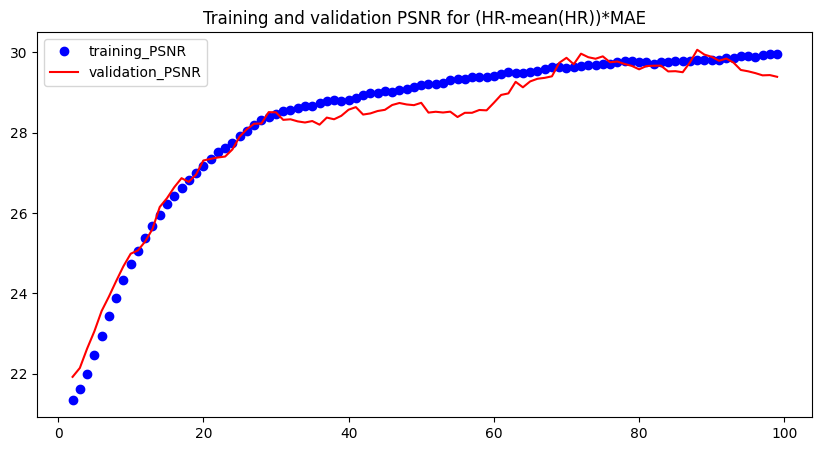

<Figure size 640x480 with 0 Axes>

In [ ]:
import pickle
import matplotlib.pyplot as plt

history_mae_x4 = pickle.load(open('./drive/MyDrive/ColabNotebooks/EDSR-Tensorflow/history/history_mae_x4', "rb"))

epochs = range(2,len(history_mae_x4["PSNR"]))

fig, ax = plt.subplots(figsize=(10,5))

ax.plot(epochs, smooth_curve(history_mae_x4["PSNR"][2:]), 'bo', label='training_PSNR')
ax.plot(epochs, smooth_curve(history_mae_x4["val_PSNR"][2:]), 'r', label='validation_PSNR')

plt.title('Training and validation PSNR for MAE')
plt.legend()

plt.figure()

plt.show()

#load model

In [ ]:
model = tf.keras.models.load_model('./drive/MyDrive/ColabNotebooks/EDSR-Tensorflow/model/model_mae_x4.h5', custom_objects={'EDSRModel':EDSRModel, 'PSNR':PSNR}) #, 'my_mae':my_mae

#Metrics for Evaluate

#PSNR

In [ ]:
def PSNR(super_resolution, high_resolution):
    """Compute the peak signal-to-noise ratio, measures quality of image."""
    # Max value of pixel is 255
    psnr_value = tf.image.psnr(high_resolution, super_resolution, max_val=255)
    return psnr_value

In [ ]:
def plot_results(highres, lowres, preds):

  #convert Tensorflow tensor to numpy for psnr y channel
  preds_float = K.cast( preds, 'float32')
  highres_float = K.cast( highres, 'float32')

  plt.figure(figsize=(24, 14))
  plt.subplot(1,3,1), plt.imshow(highres), plt.title("high resolution") #.astype(np.uint8)
  plt.subplot(1,3,2), plt.imshow(lowres), plt.title("low resolution")
  plt.subplot(1,3,3), plt.imshow(preds), plt.title("prediction(super resolution)"), plt.xlabel('PSNR:{}\n SSIM:{}\n'.format( PSNR(tf.image.rgb_to_yuv(preds_float) , tf.image.rgb_to_yuv(highres_float)) , tf.image.ssim(tf.image.rgb_to_yuv(highres_float) , tf.image.rgb_to_yuv(preds_float) , max_val=255)))
  #plt.subplot(1,4,4), plt.imshow(highres - preds), plt.title("HR - SR")
  plt.show()

#Evaluate

In [ ]:
import cv2
from glob import glob
import keras.backend as K

##just added for eagertensor to numpy error#
from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior()

ssim_y_scores = []
PSNR_y_scores = []

#source: https://stackoverflow.com/questions/74319305/creating-a-custom-image-dataset-for-super-resolution

# define the paths to the dataset
# [Set5 , Set14 , BSDS100 , Urban100 , DIV2K/DIV2K_valid_HR]
BASE_DATA_PATH = './drive/MyDrive/datasets/Set14'
HR_test_path = os.path.join(BASE_DATA_PATH ) #, 'DIV2K_valid_HR'
# [LRbicx2 , LRbicx3 , LRbicx4 , DIV2K_valid_LR_bicubic/LRbicx2]
LR_test_path = os.path.join(BASE_DATA_PATH, 'LRbicx4')

# create LR and HR image lists
LR_images = glob(LR_test_path + '/*.png')
HR_images = glob(HR_test_path + '/*.png')

# sort the lists
LR_images.sort()
HR_images.sort()

scale = 4

for i in range(len(HR_images)):

  #preprocess images
  LR_image = cv2.cvtColor(cv2.imread(LR_images[i]), cv2.COLOR_BGR2RGB)
  HR_image = cv2.cvtColor(cv2.imread(HR_images[i]), cv2.COLOR_BGR2RGB)

  #highres and preds must have the same size
  #so change the dims of highres (highres = LR_image*scale)
  #print("LR image shape:",tf.shape(LR_image))
  #print("HR image shape (Before):", tf.shape(HR_image))

  #Note:
  #shape(height,width)
  #resize(width,height)
  if(int(tf.shape(LR_image)[0]*scale) == int(tf.shape(HR_image)[0])):
    HR_image = cv2.resize(HR_image, ( int(tf.shape(LR_image)[1]*scale) , int(tf.shape(HR_image)[0]) ))
    #print("HR image shape(After):", tf.shape(HR_image))

  if(int(tf.shape(LR_image)[1]*scale) == int(tf.shape(HR_image)[1])):
    HR_image = cv2.resize(HR_image, ( int(tf.shape(HR_image)[1]) , int(tf.shape(LR_image)[0]*scale) ))
    #print("HR image shape(After):", tf.shape(HR_image))

  else:
    HR_image = cv2.resize(HR_image, (int(tf.shape(LR_image)[1]*scale), int(tf.shape(LR_image)[0]*scale) ))
    #print("HR image shape(After):", tf.shape(HR_image))

  #lowres = tf.image.random_crop(LR_image, (150, 150, 3))

  #prediction
  preds = model.predict_step(LR_image)

  #print("preds image shape:", tf.shape(preds))
  #print("****************************************")
  #plot_results(HR_image,LR_image,preds)

  #image quality calculations on Y Channel
  #convert Tensorflow tensor to numpy
  preds = K.cast( preds, 'float32')
  HR_image = K.cast( HR_image, 'float32')

  PSNR_y_scores.append(PSNR(tf.image.rgb_to_yuv(preds) , tf.image.rgb_to_yuv(HR_image)))
  ssim_y_scores.append(tf.image.ssim(tf.image.rgb_to_yuv(HR_image) , tf.image.rgb_to_yuv(preds) , max_val=255))

  # Set5 , Set14, BSDS100, Urban100, div2k
  #save sr images
  #preds = np.array(preds)
  #cv2.imwrite('./drive/MyDrive/ColabNotebooks/EDSR-Tensorflow/results/mae/Set14/sr{}.png'.format(i) , cv2.cvtColor(preds, cv2.COLOR_RGB2BGR))

  #HR_image = np.array(HR_image)
  #cv2.imwrite('./drive/MyDrive/ColabNotebooks/EDSR-Tensorflow/results/hr/Set14/hr{}.png'.format(i) , cv2.cvtColor(HR_image, cv2.COLOR_RGB2BGR))

print("\nmean PSNR: {}".format(np.mean(PSNR_y_scores)))
print("\nmean SSIM: {}".format(np.mean(ssim_y_scores)))

#reasons for difference with paper results: https://github.com/krasserm/super-resolution/issues/19

AttributeError: ignored

#PieApp and Lpips piq library

In [ ]:
!pip install piq

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.9/106.9 kB 2.2 MB/s eta 0:00:00


In [ ]:
import torch
from piq import PieAPP
from piq import LPIPS

import cv2
import os
from glob import glob
import numpy as np

##just added for eagertensor to numpy error#
from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior()

pieApp_scores = []
lpips_scores = []

pieApp = PieAPP().cuda()
lpips = LPIPS().cuda()

# define the paths to the dataset
BASE_DATA_PATH = './drive/MyDrive/'
HR_test_path = os.path.join(BASE_DATA_PATH , 'datasets/Set14')
SR_test_path = os.path.join(BASE_DATA_PATH, './drive/MyDrive/ColabNotebooks/EDSR-Tensorflow/results/mae/Set14')

# create LR and HR image lists
HR_images = glob(HR_test_path + '/*.png')
SR_images = glob(SR_test_path + '/*.png')

# sort the lists
HR_images.sort()
SR_images.sort()

for i in range(len(HR_images)):

  #preprocess images
  HR_image = cv2.cvtColor(cv2.imread(HR_images[i]), cv2.COLOR_BGR2RGB)/255
  SR_image = cv2.cvtColor(cv2.imread(SR_images[i]), cv2.COLOR_BGR2RGB)/255

  HR_image = np.transpose(HR_image , (2,0,1))
  HR_image = torch.from_numpy(HR_image).unsqueeze(0)
  HR_image = HR_image.float()

  SR_image = np.transpose(SR_image , (2,0,1))
  SR_image = torch.from_numpy(SR_image).unsqueeze(0)
  SR_image = SR_image.float()

  pieApp_scores.append(torch.abs(pieApp(HR_image,SR_image)))
  #print("\npieApp for img{}:".format(i), pieApp_scores[i])
  lpips_scores.append(lpips(HR_image,SR_image))
  #print("\nlpips for img{}:".format(i), lpips_scores[i])

pieApp_scores = torch.tensor(pieApp_scores).cpu()
lpips_scores = torch.tensor(lpips_scores).cpu()

print("\nmean pieApp: {}".format(pieApp_scores.mean()))
print("\nmean lpips: {}".format(lpips_scores.mean()))

AssertionError: ignored